# Proximity Project
Brian Li \
11/04/23

In [1]:
import geopandas as gpd
import pandas as pd
import shapely
import matplotlib.pyplot as plt

This notebook contains proximity analysis of oil wells by median household income by census tract in California.

The area data were sourced from the US Census Bureau via Michael Minn (https://michaelminn.net/tutorials/data/2015-2019-acs-states.geojson).

In [2]:
us_counties = gpd.read_file("https://michaelminn.net/tutorials/data/2015-2019-acs-counties.geojson")
us_counties = us_counties[~us_counties["ST"].isin(['AK', 'HI', 'PR'])]
us_counties = us_counties.to_crs('ESRI:102008')
analysis_state = "CA"
counties = us_counties[us_counties["ST"] == analysis_state]

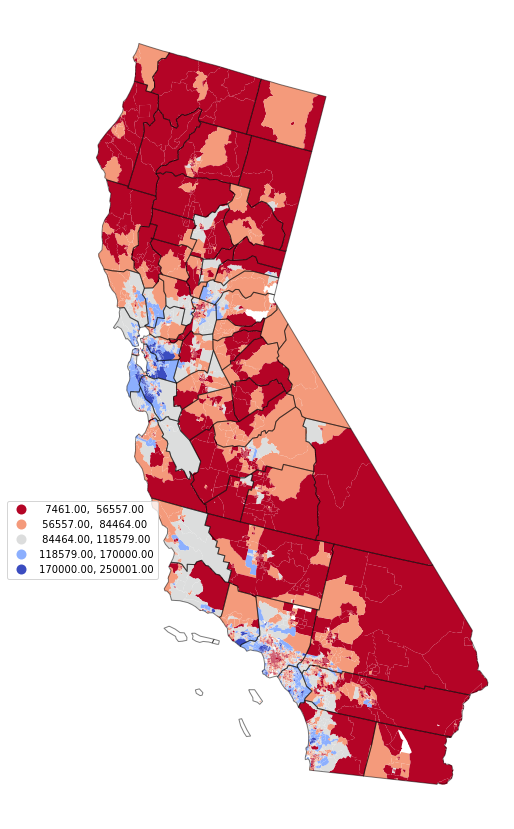

In [4]:
us_tracts = gpd.read_file("https://michaelminn.net/tutorials/data/2015-2019-acs-tracts.geojson")
tracts = us_tracts[us_tracts["ST"] == analysis_state]
tracts = tracts.to_crs('ESRI:102008')
axis = tracts.plot("Median Household Income", scheme="naturalbreaks", cmap="coolwarm_r", legend=True, edgecolor="none", figsize=(15, 15), legend_kwds={"bbox_to_anchor":(0.2, 0.4)})
counties.plot(edgecolor="#00000080", facecolor="none", ax=axis)
axis.set_axis_off()
plt.show()

This point dataset was created from two different point data sources from the California Geologic Energy Management Division (CalGEM) WellSTAR program (https://calgem-pid.conservation.ca.gov/pid/2023CaliforniaOilAndGasWellMonthlyProduction.csv and https://maps.conservation.ca.gov/doggr/wellfinder/?extent=-14916342.6686%2C3502403.2616%2C-11785481.99%2C5108192.3519%2C102100).

In [5]:
# both files HTTPS 403 Forbidden so here's some onedrive links, I guess. https://uillinoisedu-my.sharepoint.com/:x:/g/personal/brian15_illinois_edu/EdsBVnthJKZMiDdjCVDjCn4B6n1b0bM03mVBwjXFxgICZw?e=Puxg4h

monthly_prod = pd.read_csv('2023CaliforniaOilAndGasWellMonthlyProduction.csv')
wells = gpd.read_file('Oil & Gas Well.csv')

In [6]:
monthly_prod_2 = monthly_prod[["APINumber", "BTUofGasProduced", 'OilorCondensateProduced', 'GasProduced', 'WaterProduced', "DaysProducing"]]

In [7]:
monthly_prod_2 = monthly_prod_2.groupby('APINumber', as_index=False).sum()

In [8]:
monthly_prod_2 = monthly_prod_2.sort_values('BTUofGasProduced', ascending=False)
monthly_prod_2 = monthly_prod_2.reset_index(drop=True)
# weird hack because for some reason the API numbers here have extra zeros tacked on when the others dont
monthly_prod_2['APINumber'] = monthly_prod_2['APINumber']/100
monthly_prod_2.head()

,APINumber,BTUofGasProduced,OilorCondensateProduced,GasProduced,WaterProduced,DaysProducing
0,4.059217e+08,3271299.0,3938.000,1105.0000,58068.0000,90.0
1,4.111010e+08,322728.0,377.696,408.8772,190.3383,210.0
2,4.111210e+08,316400.0,412.856,400.8600,3450.3383,210.0
3,4.111010e+08,316400.0,567.240,400.8600,35.0995,210.0
4,4.111010e+08,316400.0,296.344,400.8600,125.2189,210.0


In [9]:
wells_2 = wells[['API', 'Operator Name', 'Lease Name', 'Well Type Label', 'Field Name', 'Latitude', 'Longitude']]
wells_2['API'] = wells_2['API'].astype(float)
wells_2.head()

/tmp/ipykernel_107/507600343.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wells_2['API'] = wells_2['API'].astype(float)


,API,Operator Name,Lease Name,Well Type Label,Field Name,Latitude,Longitude
0,402120521.0,"Crain Orchards, Inc.",Angel Slough,Dry Gas,Afton Gas,39.44915771,-121.94628906
1,403700673.0,The Termo Company,Orcutt,Oil & Gas,Aliso Canyon,34.31945038,-118.57151794
2,403700678.0,The Termo Company,Roosa,Oil & Gas,Aliso Canyon,34.32130814,-118.57767487
3,403722058.0,Southern California Gas Company,Standard Sesnon,Observation,Aliso Canyon,34.31829834,-118.56455994
4,403700040.0,Southern California Gas Company,Standard Sesnon,Gas Storage,Aliso Canyon,34.31272507,-118.57210541


In [10]:
well_prod = wells_2.merge(monthly_prod_2, left_on='API', right_on='APINumber')
well_prod.head()

,API,Operator Name,Lease Name,Well Type Label,Field Name,Latitude,Longitude,APINumber,BTUofGasProduced,OilorCondensateProduced,GasProduced,WaterProduced,DaysProducing
0,402120521.0,"Crain Orchards, Inc.",Angel Slough,Dry Gas,Afton Gas,39.44915771,-121.94628906,402120521.0,0.0,0.0,218.61,0.0,122.0
1,403700673.0,The Termo Company,Orcutt,Oil & Gas,Aliso Canyon,34.31945038,-118.57151794,403700673.0,9101.0,901.0,1337.00,11542.0,164.0
2,403700678.0,The Termo Company,Roosa,Oil & Gas,Aliso Canyon,34.32130814,-118.57767487,403700678.0,9092.0,1691.0,2428.00,1185.0,229.0
3,403722058.0,Southern California Gas Company,Standard Sesnon,Observation,Aliso Canyon,34.31829834,-118.56455994,403722058.0,0.0,0.0,0.00,0.0,0.0
4,403724321.0,The Termo Company,Del Aliso,Oil & Gas,Aliso Canyon,34.31782913,-118.57671356,403724321.0,8472.0,1760.0,8756.00,918.0,240.0


In [11]:
# from shapely.geometry import Point

# convert to gdf
well_prod['Latitude'] = well_prod['Latitude'].astype(float)
well_prod['Longitude'] = well_prod['Longitude'].astype(float)
# geometry = [Point(xy) for xy in zip(well_prod.Longitude, well_prod.Latitude)]
well_prod = gpd.GeoDataFrame(well_prod, crs='EPSG:4326', geometry=gpd.points_from_xy(x=well_prod.Longitude, y=well_prod.Latitude))
well_prod = well_prod.to_crs('EPSG:3310')
tracts = tracts.to_crs('EPSG:3310')

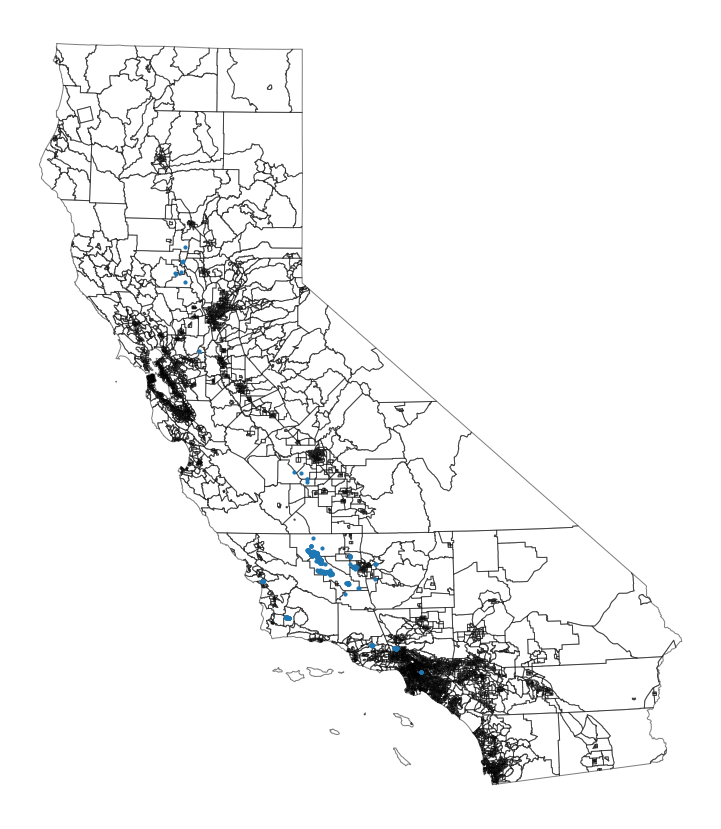

In [12]:
well_prod_tracts = well_prod.sjoin(tracts[["geometry"]])
well_prod_tracts = well_prod_tracts.drop(["index_right"], axis=1)
axis = tracts.plot(edgecolor="#00000080", facecolor="none", figsize=(15, 15))
well_prod_tracts.plot(markersize=10, ax=axis)
axis.set_axis_off()
plt.show()

I used a distance decay model from wells based on total BTU of Gas Produced so far this year.

Most if not all of the current ongoing Oil and Gas production in California happens in SoCal, mostly in the Monterey Formation around San Luis Obispo, Santa Barbara, and Kern counties.

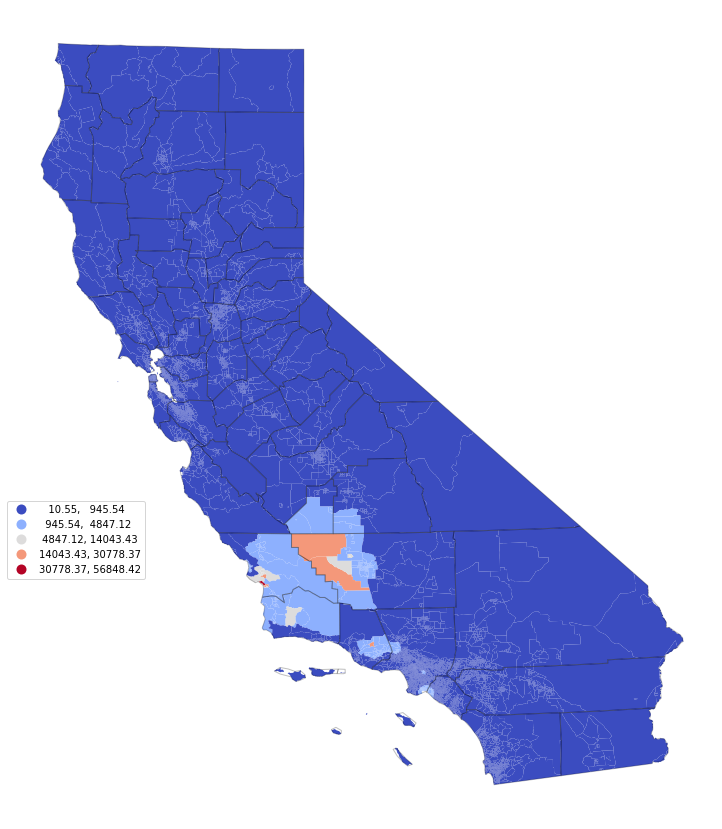

In [15]:
def area_exposure(area):
    x = well_prod['BTUofGasProduced'] / \
        (1 + (well_prod.distance(area["geometry"].centroid) / 1000))**2
    return x.sum()

counties = counties.to_crs('EPSG:3310')
tracts_2 = tracts.copy()
tracts_2["ExposureDays"] = tracts_2.apply(area_exposure, axis=1)
axis = tracts_2.plot('ExposureDays', scheme="naturalbreaks", cmap="coolwarm", edgecolor="none", figsize=(15, 15), legend=True, legend_kwds={"bbox_to_anchor":(0.2, 0.4)})
counties.plot(edgecolor="#00000040", facecolor="none", ax=axis)
axis.set_axis_off()
plt.show()

Households in census tracts with high levels of oil/gas production have slightly lower mean and median median household incomes, but the maximums are the same.

Counties dependent on oil/gas drilling are slightly poorer than the rest of the state, so creating programs to boost their economies slightly as we transition away from fossil fuels could be good.

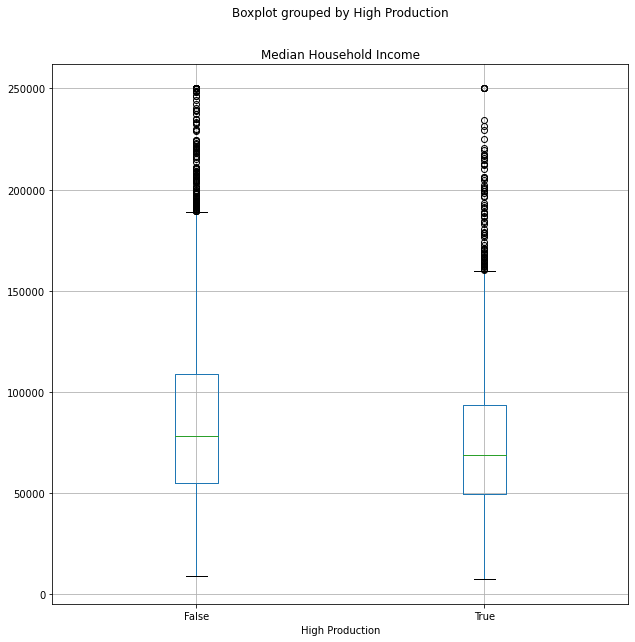

In [16]:
tracts_2["High Production"] = (tracts_2['ExposureDays'] > 150)
tracts_2.boxplot('Median Household Income', 'High Production', figsize=(10, 10))

plt.show()

In [17]:
tracts_2.groupby('High Production')['Median Household Income'].describe()

,count,mean,std,min,25%,50%,75%,max
High Production,,,,,,,,
False,4200.0,87214.531429,42590.435415,9191.0,55184.0,78172.5,108860.25,250001.0
True,3765.0,75184.212749,34386.755797,7461.0,49773.0,68988.0,93750.00,250001.0
